Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib notebook

Inputs

In [2]:
# evaporation station file
exp_name = '230211'
sample_name = '230211'
data_location = f'{exp_name}_example_data'
inFile = f'{data_location}\\{sample_name}_evap_stat.csv'
metaFile = f'{data_location}\\{sample_name}_metadata.csv'

start_time = dt.datetime(year = 2023, day = 10, month = 2, hour = 19, minute = 6)
end_time = dt.datetime(year = 2023, day = 15, month = 2, hour = 13, minute = 20)

# initial mass
mass = 21.76

# rolling average window in seconds
roll_window = 30*60

# window over which to calculate average rates of change (starting in reverse from end_time)
aroc_window = 4

# threshold of average mass % change to declare passivation (g/hr/g_init_sample)
threshold = 0.05

Functions

In [3]:
def parse_metadata(inFile):
    # import raw file from csv
    raw_df = pd.read_csv(inFile, header=None)
    
    # make row numbering the same as the google sheet
    raw_df.index += 1
    
    # make column lettering the same as the google sheet
    df_header = [chr(x+65) for x in raw_df.columns]
    raw_df.columns = df_header
    
    # pull relevant data
    start_time = dt.strptime()
    
    return raw_df

def parse_csv(inFile, roll_window):
    """
    Takes in the input file of raw data, returns a cleaned dataframe trimmed to the relevant time frame,
    as well as a dataframe based on the rolling mass average specified by roll_window.
    """
    # import raw data
    df_raw = pd.read_csv(inFile)
    # rename mass column
    df_raw = df_raw.rename(columns={'mass_ch1_ad7195_g' : 'mass_g'})
    
    # initialize clean df
    df_clean = pd.DataFrame(columns=['seconds', 'hours'])
    
    # convert date strings to datetime objects
    s = df_raw.DateTime
    d = pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S")
    df_raw.DateTime = d
    
    # create dataframe of datapoints only within specified time frame
    df_trimmed = df_raw[(df_raw.DateTime >= start_time)*(df_raw.DateTime <= end_time)]
    df_trimmed.reset_index(drop=True, inplace=True)
    
    # convert datetimes to seconds, hours elapsed
    seconds_elapsed = (df_trimmed.DateTime - start_time).dt.total_seconds()
    df_trimmed['seconds'] = seconds_elapsed
    df_trimmed['hours'] = seconds_elapsed / 3600
    
    # take rolling average on specified interval
    df_roll = df_trimmed.rolling(int(roll_window*3600), center=True).mean().dropna(how='all')
    
    return df_trimmed, df_roll

def calc_iroc(df):
    """
    Calculates the instantaneous rate of change of mass data, returned as a series.
    """
    # calculate the change between each mass measurement
    dy = df.mass_g.diff()
    
    # calculate the time change at each point in hours
    dx = df.hours.diff()
    
    # calculate rate of change
    iroc = dy/dx
    
    return iroc

def calc_aroc(df, aroc_window):
    """
    Calculates the average rate of change of mass data, returned as an array. Also returns an array of time points.
    TIME POINTS CORRESPOND TO THE END OF EACH WINDOW (i.e. averages are calculated from right to left)
    """
    window_secs = aroc_window*3600
    
    x1 = df.seconds.to_numpy()[:-window_secs]
    x2 = df.seconds.to_numpy()[window_secs:]
    y1 = df.mass_g.to_numpy()[:-window_secs]
    y2 = df.mass_g.to_numpy()[window_secs:]
    
    # calculate aroc in grams per hour
    aroc = (y2 - y1) / (x2 - x1) * 3600
    # record times in hours
    aroc_times = x2/3600
    
    return aroc, aroc_times
    

Run

In [4]:
roll_window /= 3600

df_trimmed, df_roll = parse_csv(inFile, roll_window)

arocs, aroc_times = calc_aroc(df_roll, aroc_window)

aroc_percent = arocs / mass * 100

total_rate_mass_gain = (df_roll.mass_g - df_roll.mass_g.iloc[0])[1:] / df_roll.hours[1:]

mass_gain_ratio = arocs[1:] / total_rate_mass_gain[:-aroc_window*3600]


C:\Users\fjfar\AppData\Local\Temp\ipykernel_35184\829027799.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['seconds'] = seconds_elapsed
C:\Users\fjfar\AppData\Local\Temp\ipykernel_35184\829027799.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['hours'] = seconds_elapsed / 3600
C:\Users\fjfar\AppData\Local\Temp\ipykernel_35184\829027799.py:45: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select

Plots

<IPython.core.display.Javascript object>


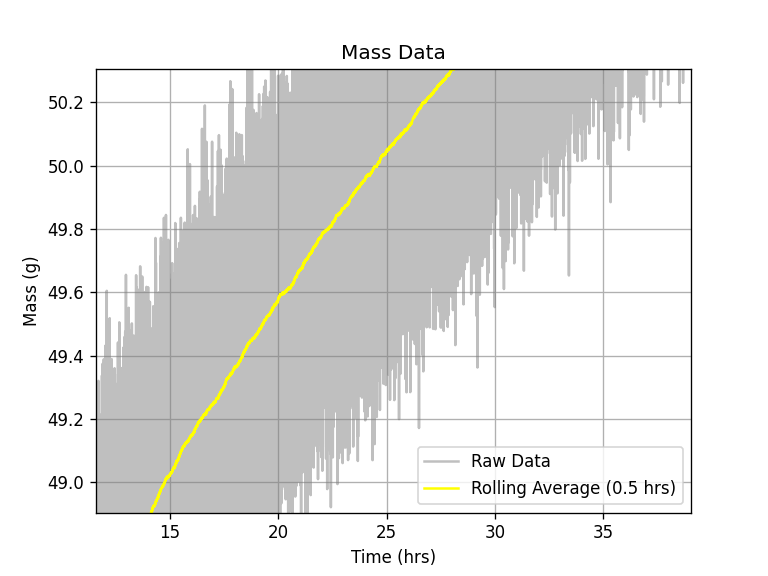

<IPython.core.display.Javascript object>


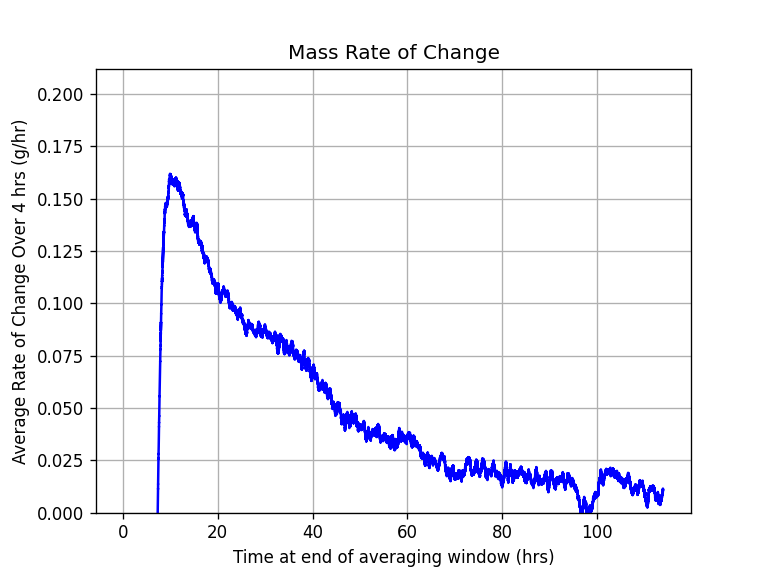

<IPython.core.display.Javascript object>


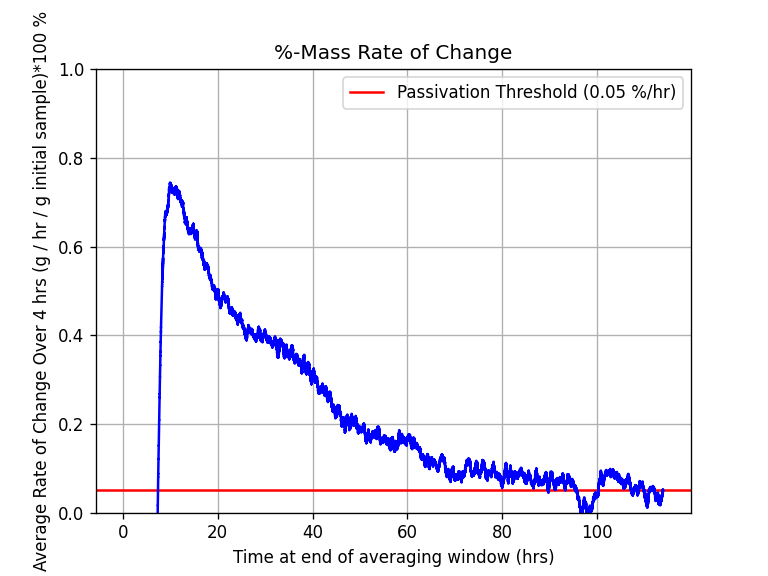

Final rate of change: 0.01 g/hr (0.05 %/hr)


In [6]:
# generate two figures
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

## mass plot
ax1.set_title('Mass Data')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Mass (g)')
# ax1.set_ylim([44, 54])

# raw data
ax1.plot(df_trimmed.hours, df_trimmed.mass_g, color='gray', alpha=0.5, label='Raw Data')

#rolling average
ax1.plot(df_roll.hours, df_roll.mass_g, color='yellow', label=f'Rolling Average ({roll_window} hrs)')

ax1.legend()
ax1.grid()

## rate of change plot
ax2.set_title('Mass Rate of Change')
ax2.set_ylabel(f'Average Rate of Change Over {aroc_window} hrs (g/hr)')
ax2.set_xlabel('Time at end of averaging window (hrs)')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(bottom=0, top=arocs.max()+0.05)

# plot aroc as line
ax2.plot(aroc_times, arocs, color='blue')
ax2.grid()

## rate of change plot, % mass
ax3.set_title('%-Mass Rate of Change')
ax3.set_ylabel(f'Average Rate of Change Over {aroc_window} hrs (g / hr / g initial sample)*100 %')
ax3.set_xlabel('Time at end of averaging window (hrs)')
ax3.axhline(y = threshold, color = 'r', linestyle = '-', label=f'Passivation Threshold ({threshold} %/hr)')
ax3.grid()
ax3.legend()
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim([0,1])

# plot aroc as line
ax3.plot(aroc_times, aroc_percent, color='blue')

print(f'Final rate of change: {arocs[-1]:.2f} g/hr ({aroc_percent[-1]:.2f} %/hr)')